In [1]:
from cassandra.cluster import Cluster
import pandas as pd

try:
    cluster = Cluster(['project-5-kc-db-1', 'project-5-kc-db-2', 'project-5-kc-db-3'])
    cass = cluster.connect()
except Exception as e:
    print(e)

In [2]:
cass.execute("drop keyspace if exists weather")

In [3]:
cass.execute("create keyspace weather with replication = {'class': 'SimpleStrategy', 'replication_factor': 3}")
cass.execute("use weather")
cass.execute("create type station_record (tmin int, tmax int)")
(cass.execute("""
    CREATE TABLE stations (
        id text,
        name text STATIC,
        date date,
        record weather.station_record,
        PRIMARY KEY (id, date)
    )
    WITH CLUSTERING ORDER BY (date ASC)
"""))

In [4]:
#q1
print(cass.execute("describe keyspace weather").one().create_statement, "\n")
print(cass.execute("describe table weather.stations").one().create_statement)

CREATE KEYSPACE weather WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '3'}  AND durable_writes = true; 

CREATE TABLE weather.stations (
    id text,
    date date,
    name text static,
    record station_record,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
    AND additional_write_policy = '99p'
    AND bloom_filter_fp_chance = 0.01
    AND caching = {'keys': 'ALL', 'rows_per_partition': 'NONE'}
    AND cdc = false
    AND comment = ''
    AND compaction = {'class': 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy', 'max_threshold': '32', 'min_threshold': '4'}
    AND compression = {'chunk_length_in_kb': '16', 'class': 'org.apache.cassandra.io.compress.LZ4Compressor'}
    AND crc_check_chance = 1.0
    AND default_time_to_live = 0
    AND extensions = {}
    AND gc_grace_seconds = 864000
    AND max_index_interval = 2048
    AND memtable_flush_period_in_ms = 0
    AND min_index_interval = 128
    AND read_repair = 'BLOCKING'


In [5]:
!python3 -m grpc_tools.protoc -I=. --python_out=. --grpc_python_out=. station.proto

In [6]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("p5")
         .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.2.0') #3.3.0 update
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .getOrCreate())

:: loading settings :: url = jar:file:/usr/local/lib/python3.10/dist-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-dd463f39-758c-4cfd-b916-6b45dc63906d;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.2.0 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.2.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.gith

In [7]:
!apt-get install zip -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  unzip
The following NEW packages will be installed:
  unzip zip
0 upgraded, 2 newly installed, 0 to remove and 4 not upgraded.
Need to get 350 kB of archives.
After this operation, 929 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 unzip amd64 6.0-26ubuntu3.1 [174 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 zip amd64 3.0-12build2 [176 kB]
Fetched 350 kB in 0s (923 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 33973 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-26ubuntu3.1_amd64.deb ...
Unpacking unzip (6.0-26ubuntu3.1) ...
Selecting previously unselected package zip.
Preparing to unpack .../zip_3.0-12build2_amd64.deb ...
Unpacking

In [8]:
import os

if not os.path.exists('ghcnd-stations.txt'):
    !wget https://pages.cs.wisc.edu/~harter/cs639/data/ghcnd-stations.txt

if not os.path.exists('wi-stations.zip'):
    !wget https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations.zip
    !unzip wi-stations.zip

In [9]:
from pyspark.sql.functions import expr

df = spark.read.text("ghcnd-stations.txt")
wi_stations_df = df.filter(df.value.substr(39, 2) == "WI")
stations_metadata_df = wi_stations_df.select(
    wi_stations_df.value.substr(0, 11).alias("id"),
    wi_stations_df.value.substr(41, 50).alias("name")
)
#stations_metadata_df.toPandas()

#df2 = df.withColumn("state", expr("substring(value, 39, 2)")) #.toPandas()
#df2 = df2[df2["state"].isin(["WI"])]

meta = cass.prepare("""INSERT INTO weather.stations (id, name) VALUES ( ?, ? )""")
for i in stations_metadata_df.collect():
    id_val, name_val = i["id"], i["name"]
    cass.execute(meta, (id_val, name_val))

In [10]:
#q2
import subprocess
output = subprocess.check_output(['nodetool', 'ring'])
print(output, "\n")


result = cass.execute("SELECT token(id) FROM weather.stations WHERE id = 'USC00470273'") 
print("row token: ", result[0][0] ) 

output_str = output.decode()
lines = output_str.splitlines()
token_numbers = []
for line in lines[5:-6]: 
    tokens = line.split()  
    token_number = tokens[-1::]
    token_numbers.append(token_number) 
    
for i in token_numbers:
    best = int(i[0])
    c=0
    if c==0 & (result[0][0]<int(i[0])):
        best=int(i[0])
        break
    elif result[0][0]<int(i[0]):
        best = int(i[0])
        c+=1
    elif result[0][0]>int(i[0]):
        if c+1==len(token_number):
            best=int(token_numbers[0][0])
            break
print("vnode token: ", best)

b'\nDatacenter: datacenter1\n==========\nAddress          Rack        Status State   Load            Owns                Token                                       \n                                                                                9162903745432330017                         \n172.19.0.3       rack1       Up     Normal  69.05 KiB       100.00%             -8948129293611142139                        \n172.19.0.3       rack1       Up     Normal  69.05 KiB       100.00%             -8103752646119980381                        \n172.19.0.2       rack1       Up     Normal  86.53 KiB       100.00%             -7962413325253462544                        \n172.19.0.4       rack1       Up     Normal  69.04 KiB       100.00%             -7693835775763322960                        \n172.19.0.2       rack1       Up     Normal  86.53 KiB       100.00%             -6890912708913429731                        \n172.19.0.3       rack1       Up     Normal  69.05 KiB       100.00%          

/tmp/ipykernel_644/389881866.py:8: DeprecationWarning: ResultSet indexing support will be removed in 4.0. Consider using ResultSet.one() to get a single row.
  print("row token: ", result[0][0] )
/tmp/ipykernel_644/389881866.py:21: DeprecationWarning: ResultSet indexing support will be removed in 4.0. Consider using ResultSet.one() to get a single row.
  if c==0 & (result[0][0]<int(i[0])):


## Part 2

In [12]:
import grpc, station_pb2_grpc, station_pb2
import sys, random
import pandas as pd
from datetime import date

channel = grpc.insecure_channel('c2583dcfcd12:5440') #CONTAINER project-5-kc-db-3: docker exec -it c2583dcfcd12 python3 /notebooks/server.py
stub = station_pb2_grpc.StationStub(channel)

def simulate_sensor(station):
    df = pd.read_csv(station + ".csv.gz")
    tempsDictionary = {}
    for line in df.itertuples():
        if str(line[2])[0:4] == "2022" and (line[3] == "TMAX" or line[3] == "TMIN"):
            stdate = str(line[2])
            stdate = date(int(stdate[0:4]), int(stdate[4:6]), int(stdate[6:8]))
            if stdate in tempsDictionary:
                temp = tempsDictionary[stdate]
                temp.append(int(line[4]))
                tempsDictionary[stdate] = temp
            else:
                temp = []
                temp.append(int(line[4]))
                tempsDictionary[stdate] = temp
    for d in tempsDictionary.keys():
        stub.RecordTemps(request = station_pb2.RecordTempsRequest(station = station, date = str(d), tmin = min(tempsDictionary[d]), tmax = max(tempsDictionary[d])))

    
for station in ["USW00014837", "USR0000WDDG", "USW00014898", "USW00014839"]:
    simulate_sensor(station)
    r = stub.StationMax(station_pb2.StationMaxRequest(station=station))
    if r.error:
        print(r.error)
    else:
        print(f"max temp for {station} is {r.tmax}")

/tmp/ipykernel_644/2490732828.py:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(station + ".csv.gz")


max temp for USW00014837 is 356
max temp for USR0000WDDG is 344


/tmp/ipykernel_644/2490732828.py:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(station + ".csv.gz")


max temp for USW00014898 is 356


/tmp/ipykernel_644/2490732828.py:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(station + ".csv.gz")


max temp for USW00014839 is 378


## Part 3

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,StringType
from pyspark.sql.functions import udf
from pyspark.sql.functions import corr

spark.conf.set("spark.sql.catalog.cassandra", "com.datastax.spark.connector.datasource.CassandraCatalog")
spark.conf.set("spark.sql.catalog.cassandra.spark.cassandra.connection.host", "project-5-kc-db-1:9042") #lec25

stations = spark.table("cassandra.weather.stations")

spark.sql("""
SELECT * 
FROM cassandra.weather.stations 
WHERE date LIKE "%2022%"
""").createOrReplaceTempView("weather2022")

spark.table("weather2022").cache()

def FahrenheitConverter(temp):
    return float((temp / 10) * (9/5) + 32)

tempUDF = udf(lambda t : FahrenheitConverter(t))
spark.udf.register("tempUDF", FahrenheitConverter)

spark.sql("show tables").show()

+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|         |weather2022|       true|
+---------+-----------+-----------+



23/05/19 22:44:47 WARN CacheManager: Asked to cache already cached data.
23/05/19 22:44:47 WARN SimpleFunctionRegistry: The function tempudf replaced a previously registered function.


<function __main__.FahrenheitConverter(temp)>

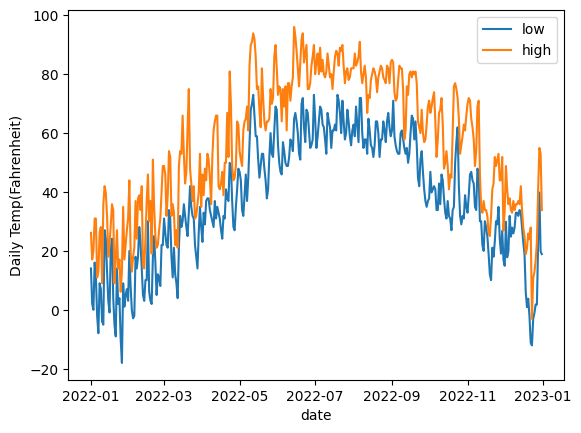

In [14]:
#q3
import matplotlib.pyplot as plt

data = spark.sql("""
SELECT id, date, tempUDF(record.tmin) as TMIN, tempUDF(record.tmax) as TMAX
FROM weather2022
WHERE id = "USW00014837"
""").toPandas()

data["TMIN"]= data['TMIN'].astype(float) #for plotting
data['TMAX'] = data['TMAX'].astype(float)

fig = data.plot.line(x = "date", y = ["TMIN", "TMAX"], ylabel = "Daily Temp (Fahrenheit)")
fig.legend(["low", "high"])

In [15]:
#q4
df = spark.sql("""
SELECT id, tempUDF(record.tmax) as TMAX
FROM weather2022
WHERE id = "USW00014837" 
""").toPandas()

df2 = spark.sql("""
SELECT id, tempUDF(record.tmax) as TMAX
FROM weather2022
WHERE id = "USW00014839"
""").toPandas()

df3 = spark.createDataFrame(zip(df["TMAX"], df2["TMAX"]), ["df", "df2"])
df3.agg(corr("df", "df2").alias("corr")).collect()

[Row(corr=0.9786907979650676)]

## Part 4

In [18]:
#q5 
stub.StationMax(station_pb2.StationMaxRequest(station="USW00014837"))

#jupyter on db-2, server on db-3, so I killed db-1
#No it doesn't work since there are only 2 container running but in the server we specified that the consistency level for StationMax is 3

23/05/19 22:45:57 WARN ChannelPool: [s0|project-5-kc-db-1/172.19.0.4:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=96e8fd71-ba3c-4b13-9e64-316753891b49, APPLICATION_NAME=Spark-Cassandra-Connector-local-1684535405983}): failed to send request (java.nio.channels.NotYetConnectedException))


error: "No temperature data found for station"

23/05/19 22:46:04 WARN ChannelPool: [s0|project-5-kc-db-1/172.19.0.4:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=96e8fd71-ba3c-4b13-9e64-316753891b49, APPLICATION_NAME=Spark-Cassandra-Connector-local-1684535405983}): failed to send request (java.nio.channels.NotYetConnectedException))


In [27]:
#q6
print( simulate_sensor("USC00477115") )

#This sometimes sucessfully runs because it only needs 1 container to run since the the consistency level was specified as 1

None


In [20]:
#q7
numberofRows = spark.sql("""
SELECT COUNT(record)
FROM weather2022
""").toPandas()

count1 = numberofRows.at[0, "count(record)"]
count1

1460

In [26]:
spark.sql("REFRESH TABLE weather2022")
simulate_sensor("USC00477115")

numberofRows2 = spark.sql("""
SELECT COUNT(record) FROM weather2022
""").toPandas()

count2 = numberofRows2.at[0, "count(record)"]

print("BEFORE REFRESH: " + str(count1))
print("AFTER REFRESH: " + str(count2))

BEFORE REFRESH: 1460
AFTER REFRESH: 1825
